# At first, play a bit with MNIST

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Check format of data

In [2]:
def print_public_fields(obj):
    for field in dir(obj):
        field_is_private = field[0] == '_' or field[1] == '_'
        if not field_is_private:
            print(field, type(getattr(obj, field)))

In [3]:
print_public_fields(mnist)

count <class 'builtin_function_or_method'>
index <class 'builtin_function_or_method'>
test <class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
train <class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
validation <class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>


In [4]:
print_public_fields(mnist.test)

epochs_completed <class 'int'>
images <class 'numpy.ndarray'>
labels <class 'numpy.ndarray'>
next_batch <class 'method'>
num_examples <class 'int'>


### Check format of images

In [11]:
from matplotlib import pyplot as plt

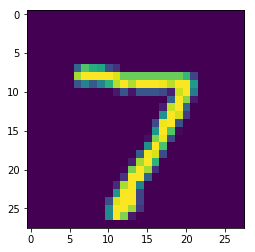

In [32]:
image = mnist.test.images[0]
image = image.reshape((28, -1))
plt.imshow(image)
plt.show()

In [31]:
print("Pixel values in range: [{}; {}]".format(image.min(), image.max()))

Pixel values in range: [0.0; 1.0]


## Training

### Simple linear regression

In [2]:
img_len = 28*28
num_classes = 10
batch_size = 64 # Play with this parameter
test_dataset_length = len(mnist.test.labels)

In [3]:
import tensorflow as tf

In [4]:
graph = tf.Graph()

with graph.as_default():
    Xs = tf.placeholder(tf.float32, shape=[None, img_len])
    Ys = tf.placeholder(tf.float32, shape=[None, num_classes])
    
    W = tf.Variable(tf.truncated_normal(shape=[img_len, num_classes]))
    b = tf.Variable(tf.zeros([num_classes]))
    
    logits = tf.matmul(Xs, W) + b
    loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(Ys, logits))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # test
    test_predictions = tf.nn.softmax(tf.matmul(Xs, W) + b)
    correct_prediction = tf.equal(tf.argmax(Ys,1), tf.argmax(test_predictions,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
num_steps = 20000

valid_data, valid_labels = mnist.validation.next_batch(batch_size)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        train_data, train_labels = mnist.train.next_batch(batch_size)
        l, _ = session.run([loss, optimizer], feed_dict={Xs: train_data, Ys: train_labels})
        if step % 2000 == 0:
            l = session.run(loss, feed_dict={Xs: valid_data, Ys: valid_labels})
            print("[{} step] Loss for validation dataset is {}".format(step, l))
    
    test_accuracy = session.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
    print("Test accuracy is ", test_accuracy)

[0 step] Loss for validation dataset is 12.888274192810059
[2000 step] Loss for validation dataset is 0.270382285118103
[4000 step] Loss for validation dataset is 0.2436733841896057
[6000 step] Loss for validation dataset is 0.2596595585346222
[8000 step] Loss for validation dataset is 0.29431813955307007
[10000 step] Loss for validation dataset is 0.21821440756320953
[12000 step] Loss for validation dataset is 0.2246493250131607
[14000 step] Loss for validation dataset is 0.2179436981678009
[16000 step] Loss for validation dataset is 0.25291672348976135
[18000 step] Loss for validation dataset is 0.24580085277557373
Test accuracy is  0.9189


Complete these tutorials by yourself.

* https://www.tensorflow.org/get_started/mnist/beginners
* https://www.tensorflow.org/get_started/mnist/pros

And read this article
http://colah.github.io/posts/2015-09-Visual-Information/

Also experiment with parameters and also try RNN from official Tensorflow tutorial on this link.
https://www.tensorflow.org/tutorials/

ALso if you have a time play with tutorials on the link above

### Simple convolution neural network 

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [10]:
num_classes = 10

In [20]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, num_classes])
    
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y_conv, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict = {x: batch[0], y_: batch[1], keep_prob: 1.0})
            print("step {}, training accuracy {}".format(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
    print("test accuracy {}".format(accuracy.eval(feed_dict={
                    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))

step 0, training accuracy 0.05999999865889549
step 100, training accuracy 0.8799999952316284
step 200, training accuracy 0.9399999976158142
step 300, training accuracy 0.8999999761581421
step 400, training accuracy 0.9599999785423279
step 500, training accuracy 0.9599999785423279
step 600, training accuracy 0.9599999785423279
step 700, training accuracy 0.9599999785423279
step 800, training accuracy 0.9200000166893005
step 900, training accuracy 0.9800000190734863
step 1000, training accuracy 0.9599999785423279
step 1100, training accuracy 1.0
step 1200, training accuracy 0.8799999952316284
step 1300, training accuracy 1.0
step 1400, training accuracy 1.0
step 1500, training accuracy 0.9599999785423279
step 1600, training accuracy 0.9599999785423279
step 1700, training accuracy 0.9800000190734863
step 1800, training accuracy 0.9599999785423279
step 1900, training accuracy 0.9800000190734863
step 2000, training accuracy 1.0
step 2100, training accuracy 0.9800000190734863
step 2200, trai